### Import Packages and set parameters

In [1]:
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os.path import join, exists, splitext
from moviepy.editor import VideoFileClip
from camera_calibration import CameraCalibration
from detection_pipeline import LaneLineDetector
%matplotlib inline

cam = CameraCalibration()
cam.calibrate_camera()
det = LaneLineDetector(cam)

# Calibration initialized ...
# Camera calibrated with: 20 images


### Preparation: Camera calibration

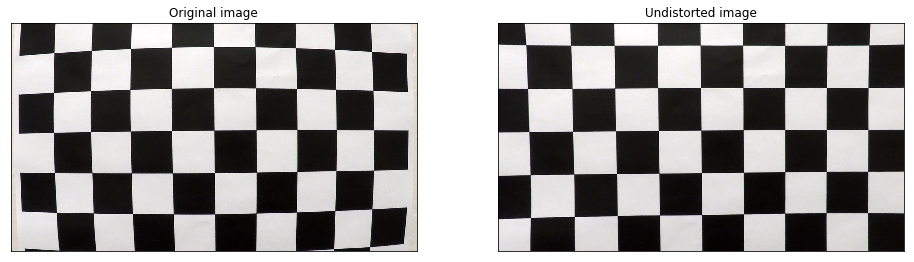

In [2]:
plt.figure(figsize=(16,9))
image = mpimg.imread("camera_cal/calibration1.jpg")
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Undistorted image")
plt.xticks([]), plt.yticks([])
plt.imshow(cam.undistort(image))
plt.show()

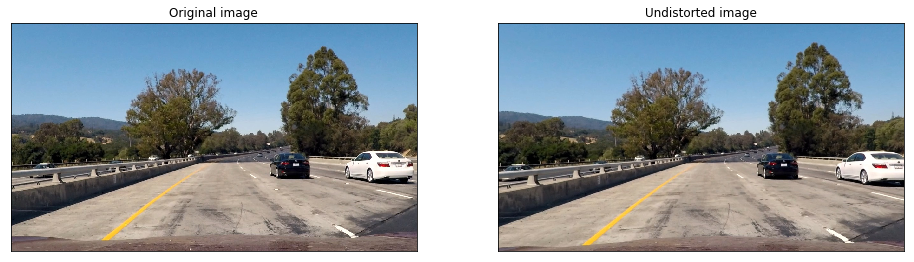

In [3]:
plt.figure(figsize=(16,9))
image = mpimg.imread("test_images/test1.jpg")
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Undistorted image")
plt.xticks([]), plt.yticks([])
plt.imshow(cam.undistort(image))
plt.show()

### Preparation: Warp images

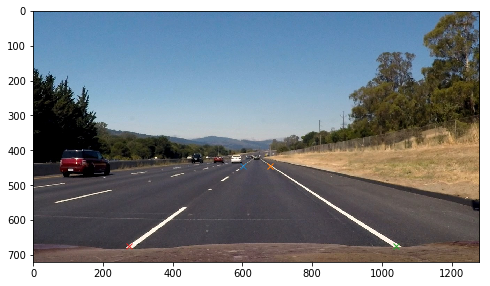

In [4]:
plt.figure(figsize=(8,9))
image = mpimg.imread("./test_images/straight_lines2.jpg")
plt.imshow(image)
for n in range(4):
    plt.plot(cam.src[n][0], cam.src[n][1], 'x')
plt.show()

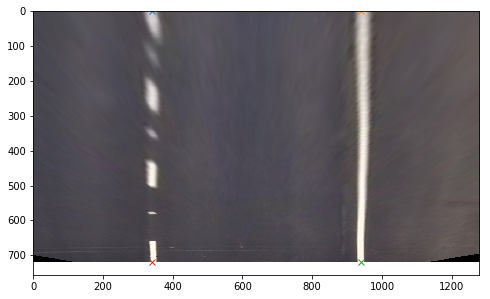

In [5]:
plt.figure(figsize=(8,9))
warped = cam.warp(cam.undistort(image))
plt.imshow(warped)
for n in range(4):
    plt.plot(cam.dst[n][0], cam.dst[n][1], 'x')
plt.show()

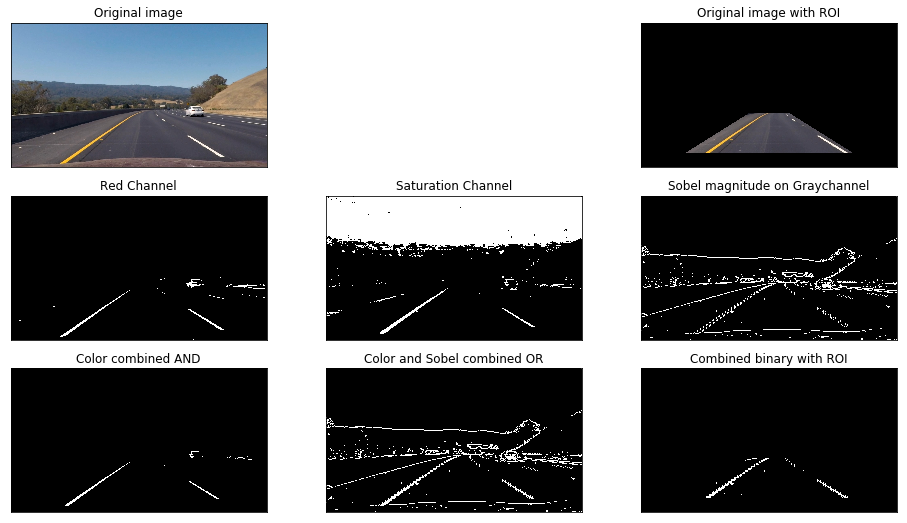

In [6]:
m = 3
n = 3
image = mpimg.imread("./test_images/test3.jpg")
plt.figure(figsize=(16,9))
undist = cam.undistort(image)
corr_red = det.color_RGB(undist, 0)
binary_red = det.create_binary(corr_red)
binary_red[(corr_red >= det.THRESH_CORR_RED[0]) & (corr_red <= det.THRESH_CORR_RED[1])] = 1
corr_sat = det.color_HLS(image, 2)
binary_sat = det.create_binary(corr_sat)
binary_sat[(corr_sat >= det.THRESH_CORR_SAT[0]) & (corr_sat <= det.THRESH_CORR_SAT[1])] = 1
sobelx = det.sobel(det.grayscale(image), 'x', det.KERNEL_SOBEL)
sobely = det.sobel(det.grayscale(image), 'y', det.KERNEL_SOBEL)
sobel_mag = det.magnitude(sobelx, sobely)
sobel_binary = det.create_binary(sobel_mag)
sobel_binary[(sobel_mag >= det.THRESH_SOBEL_MAG[0]) & (sobel_mag <= det.THRESH_SOBEL_MAG[1])] = 1
color_binary = det.create_binary(binary_red)
color_binary[(binary_red == 1) & (binary_sat == 1)] = 1
combined_binary = det.create_binary(binary_red)
combined_binary[(color_binary == 1) | (sobel_binary == 1)] = 1
masked_raw = det.region_of_interest(undist, det.VERTICES)
masked = det.region_of_interest(combined_binary, det.VERTICES)

plt.subplot(m,n,1)
plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.imshow(undist)

plt.subplot(m,n,3)
plt.title("Original image with ROI")
plt.xticks([]), plt.yticks([])
plt.imshow(masked_raw)

plt.subplot(m,n,4)
plt.title("Red Channel")
plt.xticks([]), plt.yticks([])
plt.imshow(binary_red, cmap='gray')

plt.subplot(m,n,5)
plt.title("Saturation Channel")
plt.xticks([]), plt.yticks([])
plt.imshow(binary_sat, cmap='gray')

plt.subplot(m,n,6)
plt.title("Sobel magnitude on Graychannel")
plt.xticks([]), plt.yticks([])
plt.imshow(sobel_binary, cmap='gray')

plt.subplot(m,n,7)
plt.title("Color combined AND")
plt.xticks([]), plt.yticks([])
plt.imshow(color_binary, cmap='gray')

plt.subplot(m,n,8)
plt.title("Color and Sobel combined OR")
plt.xticks([]), plt.yticks([])
plt.imshow(combined_binary, cmap='gray')

plt.subplot(m,n,9)
plt.title("Combined binary with ROI")
plt.xticks([]), plt.yticks([])
plt.imshow(masked, cmap='gray')

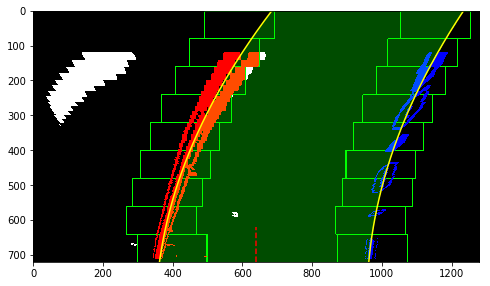

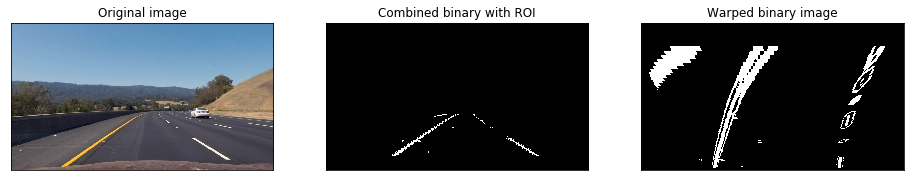

In [8]:
m = 1
n = 3
plt.figure(figsize=(8,9))
warp = cam.warp(masked)
warp_lane, fit_l, fit_r, off = det.find_line(warp, plot=True)
r_left, r_right = det.measuring_curvature(warp_lane, fit_l, fit_r)
lane = cam.unwarp(warp_lane)
final = det.draw_line(undist, lane)
final_txt = det.background_for_text(final, 100)
final_txt = det.text_on_image(final_txt, r_left, r_right, off)
pipeline_test = det.pipeline(image)

plt.figure(figsize=(16,9))
plt.subplot(m,n,1)
plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.imshow(undist)

plt.subplot(m,n,2)
plt.title("Combined binary with ROI")
plt.xticks([]), plt.yticks([])
plt.imshow(masked, cmap='gray')

plt.subplot(m,n,3)
plt.title("Warped binary image")
plt.xticks([]), plt.yticks([])
plt.imshow(warp, cmap='gray')


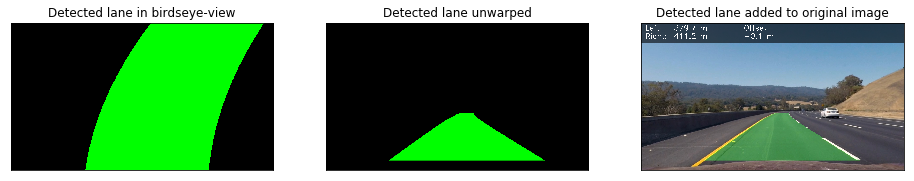

In [10]:
m = 1
n = 3
plt.figure(figsize=(16,9))
plt.subplot(m,n,1)
plt.title("Detected lane in birdseye-view")
plt.xticks([]), plt.yticks([])
plt.imshow(warp_lane)

plt.subplot(m,n,2)
plt.title("Detected lane unwarped")
plt.xticks([]), plt.yticks([])
plt.imshow(lane)

plt.subplot(m,n,3)
plt.title("Detected lane added to original image")
plt.xticks([]), plt.yticks([])
plt.imshow(final)